## Load packages and data

In [97]:
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from modeling import get_classifier_scores, get_classifier_performance

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
df = pickle.load(open("processed_data.pickle", "rb"))

## Model 1: "Conduct Occurred" ruling
This model will apply to the entire dataset, and try to predict whether the CCRB determines that a complaint did occur (i.e. was ruled "substantiated" or "exonerated").

### Define features + target,  preprocessing steps and to train/test split

In [106]:
# define features and target
# consider adding precinct as categorical variable
features_list = ['mos_age_incident', 'complainant_age_incident', 'complaint_age', 'complaint_is_grouped',
                 'officer_cumcount', 'command_rank_num', 'percent_unemployed_mean', 'percent_nohs_mean', 'mos_ethnicity',
                 'mos_gender', 'complainant_ethnicity', 'complainant_gender', 'fado_type', 'contact_reason', 'outcome_description']

X1 = df[features_list]
y1 = df['ruling_conduct_occurred']

In [107]:
# define numeric and categorical features
numeric_features = ['mos_age_incident', 'complainant_age_incident', 'complaint_age', 'officer_cumcount',
                    'command_rank_num', 'percent_unemployed_mean', 'percent_nohs_mean']
categorical_features = ['mos_ethnicity', 'mos_gender', 'complainant_ethnicity', 'complainant_gender',
                        'fado_type', 'contact_reason', 'outcome_description']

In [108]:
# create preprocessor pipeline steps to process numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [109]:
# split data into training and test set
X1, X1_test, y1, y1_test = train_test_split(
    X1, y1, test_size=.2, random_state=33) 

### Try a bunch of classifiers with cross-validation

In [74]:
clf_models_list = [
    LogisticRegression(max_iter=500),
    RandomForestClassifier(random_state=33),
    KNeighborsClassifier(3),
    SVC(random_state=33),
    GradientBoostingClassifier(random_state=33),
    GaussianNB()
    ]

In [75]:
# test the same set of classifiers using same preprocessing techniques
get_classifier_scores(X1,y1,clf_models_list,preprocessor)

LogisticRegression(max_iter=500)
0.6194487813409999
RandomForestClassifier(random_state=33)
0.6729936863685682
KNeighborsClassifier(n_neighbors=3)
0.621082744673315
SVC(random_state=33)
0.632559171720154
GradientBoostingClassifier(random_state=33)
0.6369735786290469
GaussianNB()
0.601306467148313


Looks like Random Forest fits my data best of the models tried. Now I'll examine some additional metrics and then see if I can optimize the model.

### Baseline Random Forest Performance Metrics

              precision    recall  f1-score   support

           0       0.67      0.62      0.64     10844
           1       0.67      0.72      0.70     11810

    accuracy                           0.67     22654
   macro avg       0.67      0.67      0.67     22654
weighted avg       0.67      0.67      0.67     22654



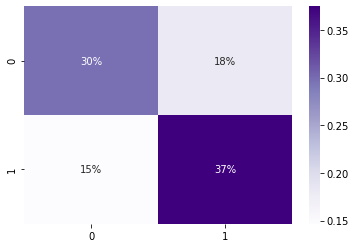

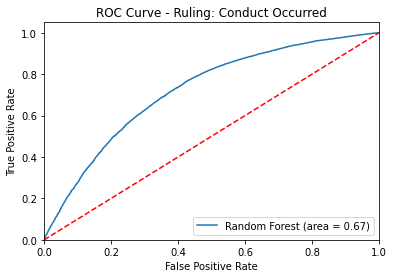

In [110]:
get_classifier_performance(X=X1,y=y1,model=RandomForestClassifier(),preprocessor=preprocessor)

## Model 2: "Violated Rules" ruling
This model will apply only to complaints that the CCRB determined _did_ occur, and try to predict whether the complaint is ruled "substantiated" (the officer's conduct violated rules) or "exonerated" (the officer's conduct did not violate NYPD rules).\

### Define features + target,  preprocessing steps and to train/test split
Will use the same set of preprocessing steps as Model 1, since features are the same.

In [15]:
# filter out any "unsubstantiated" complaints and save as new dataframe
indexNames = df[df['disposition_clean'] == 'Unsubstantiated'].index
df2 = df.drop(indexNames)

# define X and y for 'violated rules' model
X2 = df2[features_list]
y2 = df2['ruling_conduct_violated_rules']

In [16]:
# split into training and test set
X2, X2_test, y2, y2_test = train_test_split(
    X2, y2, test_size=.2, random_state=33) 

In [21]:
# test the same set of classifiers using same preprocessing techniques
get_classifier_scores(X2,y2,clf_models_list,preprocessor)

LogisticRegression(max_iter=500)
0.6907998642918216
RandomForestClassifier(random_state=33)
0.7530133122231721
KNeighborsClassifier(n_neighbors=3)
0.687574381983947
SVC(random_state=33)
0.7087091299765969
GradientBoostingClassifier(random_state=33)
0.716262507446302
GaussianNB()
0.594296078653118


Looks like Random Forest is fitting my data best. Now I'll check to see whether it can be optimized.

### Baseline Random Forest Performance Metrics

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      6222
           1       0.74      0.74      0.74      5560

    accuracy                           0.75     11782
   macro avg       0.75      0.75      0.75     11782
weighted avg       0.75      0.75      0.75     11782



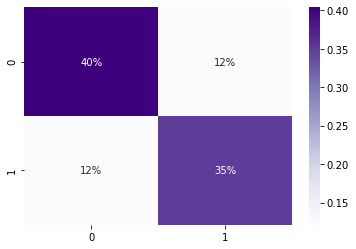

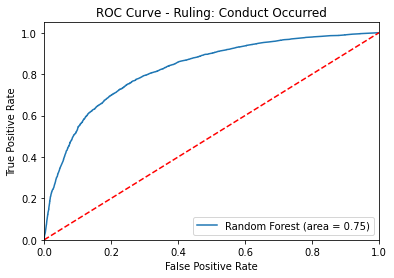

In [104]:
get_classifier_performance(X=X2,y=y2,model=RandomForestClassifier(),preprocessor=preprocessor)